In [1]:
import pandas as pd
from pathlib import Path
import sys

# sys.path.append(str(Path(__file__).parent.parent))
sys.path.append("..")
from utils.load import load_embeddings_dataset, clean_metadata_column
import pyarrow.parquet as pq
import numpy as np
from graphviz import Graph
import igraph

igraph.config["plotting.backend"] = "matplotlib"
from igraph import Graph, plot
from utils.graph_visualization import visualize_graph
from utils.graph_clustering import spectral_clustering, to_knn_similarity, reduce_dim
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from utils.internal_validation_metrics import manual_silhouette_score

# from utils.external_validation import plot_merged_attribute_heatmap
import seaborn as sns
import textwrap
import ast
from scipy.stats import chi2
# from utils.kl_matrix import create_kl_adjacency
# from utils.internal_validation_metrics import (
#     manual_silhouette_score,
#     manual_dbi,
#     manual_average_dispersion,
# )
from IPython.display import display

# CTM-based Graph Clustering

### Load parquet file

In [ ]:
# Read Parquet with PyArrow, keeping pandas metadata
table = pq.read_table("../data/sequence_dataset.parquet", use_pandas_metadata=True)
df = table.to_pandas()
display(df.head(5))


# Robust CTM stacking that unwraps singleton nesting and coerces to float array
def stack_ctm(entry):
    import ast

    e = entry
    # unwrap extra singleton nesting like [[...]] -> [...]
    while isinstance(e, (list, tuple)) and len(e) == 1:
        e = e[0]

    # if stored as a string, try to parse it
    if isinstance(e, str):
        e = ast.literal_eval(e)

    arr = np.array(e, dtype=object)

    # if object dtype, try to build numeric rows
    if arr.dtype == object:
        try:
            rows = [np.asarray(r, dtype=float) for r in arr]
            arr = np.vstack(rows)
        except Exception as exc:
            raise ValueError(f"Cannot convert CTM entry to numeric array: {exc}")

    # handle an extra leading singleton dimension (1,129,129)
    if arr.ndim == 3 and arr.shape[0] == 1 and arr.shape[1:] == (129, 129):
        arr = arr.squeeze(0)

    if arr.shape != (129, 129):
        raise ValueError(f"Unexpected CTM shape {arr.shape}; expected (129,129)")

    return arr.astype(float)


def normalize_global(M: np.ndarray) -> np.ndarray:
    total = M.sum()
    return M / total if total != 0 else M.astype(float)


# Apply conversion + normalization with index-aware errors for easier debugging
ctm_matrices = []
for i, e in enumerate(df["ctm"]):
    try:
        mat = stack_ctm(e)
        mat = normalize_global(mat)
        ctm_matrices.append(mat)
    except Exception as exc:
        raise ValueError(f"Error processing ctm at row {i}: {exc}")

df["ctm_matrix"] = ctm_matrices

# Quick verification
print("Rows:", len(df))
print("Example shape (row 0):", df.loc[0, "ctm_matrix"].shape)
print("Sum of example (row 0):", df.loc[0, "ctm_matrix"].sum())
# Optionally check that every matrix sums to 1 (or 0 if originally all zeros)
sums = df["ctm_matrix"].apply(np.sum)
print("Number of matrices with sum == 1:", (np.isclose(sums, 1.0)).sum())
print("Number of zero-sum matrices:", (sums == 0).sum())

In [ ]:
p = Path("../data") / "ctms_distance_matrix.npy"

if p.exists():
    print("Distance matrix already exists; loading from file.")
    distance_matrix = np.load(p)
else:
    ctms_list = df["ctm_matrix"].tolist()
    distance_matrix = create_kl_adjacency(ctms_list)
    np.save(p, distance_matrix)

## Spectral clustering

### Distances to similarity

Compute a locally scaled similarity matrix using k-NN distances and adaptive Gaussian kernels.


In [ ]:
import numpy as np
from sklearn.neighbors import NearestNeighbors


def distance_to_local_scaled_similarity(
    D: np.ndarray, k: int = 15, scale_factor: float = 2.0
) -> np.ndarray:
    """
    Robust Self-Tuning Spectral Clustering.
    1. Uses mean distance for sigma (prevents tiny sigma from duplicates).
    2. Adds a scale_factor to widen the Gaussian kernel.
    """
    n = D.shape[0]

    # 1. k-NN search
    # Request k+1 because the first neighbor is self (dist=0)
    nbrs = NearestNeighbors(n_neighbors=k + 1, metric="precomputed")
    nbrs.fit(D)
    knn_dists, knn_indices = nbrs.kneighbors(D)

    # 2. Calculate ROBUST Sigmas
    # Instead of just the k-th neighbor, use the MEAN of the k neighbors.
    # This prevents 'collapsing' if the first few neighbors are duplicates.
    # scale_factor (e.g. 2.0) ensures the tail of the distribution doesn't vanish too fast.
    sigmas = np.mean(knn_dists[:, 1:], axis=1) * scale_factor

    # Safety: prevent division by zero if all neighbors are identical
    avg_global_dist = np.mean(knn_dists[:, 1:]) + 1e-9
    sigmas[sigmas < 1e-9] = avg_global_dist

    sim_matrix = np.zeros((n, n))

    # 3. Compute Weights
    for i in range(n):
        neighbors = knn_indices[i, 1:]

        # Original squared distances
        d_sq = knn_dists[i, 1:] ** 2

        # Scaling denominator: sigma_i * sigma_j
        # This is the Zelnik-Manor magic: it adapts to the density of BOTH points.
        sigma_prod = sigmas[i] * sigmas[neighbors]

        # Compute Gaussian
        weights = np.exp(-d_sq / sigma_prod)

        # Hard check: If weights are still microscopic, clip them to a minimum
        # This ensures the graph doesn't mathematically sever.
        weights[weights < 1e-4] = 1e-4

        sim_matrix[i, neighbors] = weights

    # 4. Symmetrize (Maximum preserves the strongest connection)
    sim_matrix = np.maximum(sim_matrix, sim_matrix.T)
    np.fill_diagonal(sim_matrix, 0)

    return sim_matrix


sim_matrix = distance_to_local_scaled_similarity(
    distance_matrix, k=15, scale_factor=2.0
)

### Spectral Embedding + k-Means

Run spectral clustering: load cached results or compute Laplacian, eigenvectors, k-means labels, and clustering quality metrics, then save everything.

In [ ]:
import pickle
from pathlib import Path
from scipy.linalg import fractional_matrix_power
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans

# File to save/load clustering results
p_clusters = Path("../data/ctms_clusters.pkl")
k_values = range(2, 15)

if p_clusters.exists():
    print("Clustering results already exist; loading from file.")
    with open(p_clusters, "rb") as f:
        results = pickle.load(f)
    labels_all = results["labels_all"]
    scores = results["silhouette_scores"]
    dbi_scores = results["dbi_scores"]
    mod_scores = results["modularity_scores"]
    X_norm_all = results.get("X_norm_all", None)  # load if saved
else:
    from scipy.linalg import eigh

    # Compute Laplacian
    D = np.diag(sim_matrix.sum(axis=1))
    D_inv_sqrt = fractional_matrix_power(D, -0.5)
    L_sym = np.eye(sim_matrix.shape[0]) - D_inv_sqrt @ sim_matrix @ D_inv_sqrt

    scores = []
    dbi_scores = []
    avg_dispersion = []
    labels_all = {}  # store labels for each k
    X_norm_all = {}  # store normalized eigenvectors for each k

    for k in k_values:
        eigvals, eigvecs = eigh(L_sym)
        X = eigvecs[:, :k]
        X_norm = normalize(X, norm="l2", axis=1)
        X_norm_all[k] = X_norm  # save normalized vectors

        labels = KMeans(n_clusters=k, random_state=42).fit_predict(X_norm)
        labels_all[k] = labels

        # silhouette
        sill = manual_silhouette_score(X_norm, labels)
        scores.append(sill)

        # Davies–Bouldin Index (lower is better)
        dbi = manual_dbi(X_norm, labels)
        dbi_scores.append(dbi)

        # average dispersion
        dispersion = manual_average_dispersion(X_norm_all[k], labels_all[k])
        avg_dispersion.append(dispersion)

    # save results including X_norm_all
    with open(p_clusters, "wb") as f:
        pickle.dump(
            {
                "labels_all": labels_all,
                "silhouette_scores": scores,
                "dbi_scores": dbi_scores,
                "average_dispersion_scores": avg_dispersion,
                "X_norm_all": X_norm_all,
            },
            f,
        )

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create the figure
plt.figure(figsize=(10, 6))

# 1. Silhouette (Higher is Better) - Solid Green
plt.plot(k_values, scores, "g--s", linewidth=2, label="Silhouette (Max is better)")

# 2. DBI (Lower is Better) - Dashed Red
plt.plot(k_values, dbi_scores, "r--o", linewidth=2, label="DBI (Min is better)")

# 3. Dispersion (Lower is Better) - Dashed Blue
plt.plot(
    k_values, avg_dispersion, "b--^", linewidth=2, label="Dispersion (Min is better)"
)

plt.legend(loc="best", frameon=True)

# Mark k=8:
try:
    idx_k8 = list(k_values).index(8)
except ValueError:
    # fallback if k_values is not a plain sequence
    idx_k8 = int(np.where(np.array(list(k_values)) == 8)[0][0])

y_sil_k8 = scores[idx_k8]
y_dbi_k8 = dbi_scores[idx_k8]
y_disp_k8 = avg_dispersion[idx_k8]

# Vertical line at k=8
plt.axvline(x=8, color="gray", linestyle="--", linewidth=1.5, label="k = 8")

# Horizontal lines at the three metric values at k=8
plt.hlines(
    y_sil_k8,
    xmin=min(k_values),
    xmax=max(k_values),
    colors="green",
    linestyles=":",
    linewidth=1.5,
    label=f"Silhouette @k=8 ({y_sil_k8:.3f})",
)
plt.hlines(
    y_dbi_k8,
    xmin=min(k_values),
    xmax=max(k_values),
    colors="red",
    linestyles=":",
    linewidth=1.5,
    label=f"DBI @k=8 ({y_dbi_k8:.3f})",
)
plt.hlines(
    y_disp_k8,
    xmin=min(k_values),
    xmax=max(k_values),
    colors="blue",
    linestyles=":",
    linewidth=1.5,
    label=f"Dispersion @k=8 ({y_disp_k8:.3f})",
)

plt.xlabel("Number of Clusters (k)", fontsize=12)
plt.ylabel("Score Value", fontsize=12)
plt.title("Cluster Validation Metrics Comparison", fontsize=14)
plt.grid(True, alpha=0.3)

plt.show()

### Pick the best $k$

In [ ]:
best_k = 8
best_labels = labels_all[best_k]
print("Chosen k:", best_k)
print(
    f"Silhouette score for k={best_k}: {manual_silhouette_score(X_norm_all[best_k], best_labels):.4f}"
)

In [ ]:
# Ensure matrices_df exists (build from df if missing)
if "matrices_df" not in globals():
    if "ctm_matrix" in df.columns:
        matrices_df = df[["ctm_matrix"]].rename(columns={"ctm_matrix": "ctm"}).copy()
    elif "ctm" in df.columns:
        matrices_df = df[["ctm"]].copy()
    else:
        raise ValueError(
            "Cannot build matrices_df: neither 'ctm_matrix' nor 'ctm' found in df."
        )
    matrices_df.index.name = "song_idx"

# Choose labels: prefer best_labels, fall back to other globals if necessary
if "best_labels" in globals():
    labels = best_labels
elif "labels" in globals():
    labels = labels
elif "labels_all" in globals() and "best_k" in globals():
    labels = labels_all[best_k]
else:
    raise ValueError(
        "No clustering labels found in globals (expected 'best_labels' or 'labels')."
    )

Attach final cluster labels to the dataframe, safely serialize array columns, write the updated parquet file, and print sample items per cluster.

In [ ]:
# Align labels with how clustering was stored and write back to the original parquet
if "labels" in globals():
    labels_array = np.asarray(labels)
elif "best_k" in globals() and "labels_all" in globals():
    labels_array = np.asarray(labels_all[best_k])
else:
    raise ValueError(
        "No clustering labels found ('labels' or 'labels_all' with 'best_k')."
    )

# Sanity check
if len(labels_array) != len(df):
    raise ValueError(f"Length mismatch: labels ({len(labels_array)}) vs df ({len(df)})")

# Add cluster column to the dataframe
df["cluster_number"] = labels_array.astype(int)

# Write the parquet with the new column
p_path = Path("../data") / "sequence_dataset_clusters.parquet"

# Module-level import at top of cell
import pyarrow as pa

# PyArrow cannot directly convert 2D numpy arrays in a pandas column.
# Convert the 'ctm_matrix' column to nested Python lists (serializable) or drop it
# from the table if you don't want to save it.
df_to_save = df.copy()

if "ctm_matrix" in df_to_save.columns:
    # Convert numpy arrays (129x129) to nested lists so PyArrow can handle them.
    df_to_save["ctm_matrix_serialized"] = df_to_save["ctm_matrix"].apply(
        lambda m: m.tolist()
        if isinstance(m, np.ndarray)
        else (m if isinstance(m, list) else None)
    )
    # It's safer to drop the original numpy-array column to avoid Arrow errors.
    df_to_save = df_to_save.drop(columns=["ctm_matrix"])

# Build PyArrow table and write parquet (pq was imported earlier in the notebook)
table = pa.Table.from_pandas(df_to_save, preserve_index=False)
pq.write_table(table, p_path)
print(f"Saved parquet with new column 'cluster_number' to {p_path}")

# Print representative titles (or indices if 'title' missing) per cluster
num_clusters = int(labels_array.max()) + 1
for cluster_id in range(num_clusters):
    mask = df["cluster_number"] == cluster_id
    n = int(mask.sum())
    if "title" in df.columns:
        items = df.loc[mask, "title"].head(10).values
    else:
        items = df.index[mask][:10].tolist()
    print(f"\nCluster {cluster_id + 1} (n={n}):")
    print(items)

# Visualize again head of parquet with new cluster_number column
display(df.head(1))

### External Validation and graph visualization

Visualize the graphs using the forceatlas2 library and save them in the results folder.

In [ ]:
from utils.external_validation import plot_merged_attribute_heatmap

plot_merged_attribute_heatmap(df, labels_all[best_k], top_n=6)

In [ ]:
from graph_visualization import visualize_graph

visualize_graph(
    sim_matrix, labels_all[best_k], filename="CTM_based_graph_visualization.png"
)

In [ ]:
from utils.metrics import column_wise_summary

df['cluster_label'] = df['cluster_number']
column_metrics = column_wise_summary(
    df,
    columns = ["name", "themes", "keywords", "involved_companies", "first_release_year"],
    save_path="ctms_column_summary.json"
)

In [26]:
def plot_metadata_distributions(data, top_n=10):
    """
    Plot distributions for metadata categories from a JSON-like dict.
    For each category, creates a single figure with subplots showing each cluster 
    compared to the global distribution, using tab10 color scheme.

    Expected structure:
    {
      "0": {
          "name": {"counts": {...}},
          "themes": {"counts": {...}},
          "keywords": {"counts": {...}},
          "involved_companies": {"counts": {...}},
          "first_release_year": {"counts": {...}}
      },
      "1": {...},  # optionally more clusters
    }

    Parameters
    ----------
    data : dict
        Parsed JSON dictionary.
    top_n : int
        Number of top values to plot for categorical variables.
    """
    import matplotlib.pyplot as plt
    from matplotlib import cm
    
    # Get tab10 colormap
    tab10 = cm.get_cmap('tab10')
    
    cluster_sizes = {id: data[id].get('cluster_size', 0) for id in data}
    cluster_ids = sorted(data.keys(), key=lambda x: int(x))
    n_clusters = len(cluster_ids)
    
    # Collect all categories (excluding cluster_size)
    categories = set()
    for cluster_dict in data.values():
        for key in cluster_dict.keys():
            if key != "cluster_size" and "counts" in cluster_dict.get(key, {}):
                categories.add(key)
    
    # Compute global distributions for each category
    global_distributions = {}
    for category in categories:
        global_dist = {}
        for cluster_id in cluster_ids:
            cluster_dict = data[cluster_id]
            if category in cluster_dict and "counts" in cluster_dict[category]:
                counts = cluster_dict[category]["counts"]
                for item, count in counts.items():
                    global_dist[item] = global_dist.get(item, 0) + count
        global_distributions[category] = global_dist
    
    # Process each category
    for category in sorted(categories):
        print(f"\n=== {category} ===")
        
        # Determine if this is year data
        is_year = category == "first_release_year"
        
        # Create subplot grid (clusters + 1 for global)
        n_plots = n_clusters + 1
        n_cols = min(3, n_plots)
        n_rows = (n_plots + n_cols - 1) // n_cols
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 4*n_rows))
        if n_plots == 1:
            axes = [axes]
        else:
            axes = axes.flatten() if n_rows > 1 else list(axes)
        
        # Plot global distribution first
        ax = axes[0]
        global_counts = global_distributions[category]
        
        if is_year:
            # Year histogram
            years = []
            freqs = []
            for k, v in global_counts.items():
                try:
                    years.append(int(k))
                    freqs.append(v)
                except ValueError:
                    continue
            
            if years:
                sorted_data = sorted(zip(years, freqs))
                years, freqs = zip(*sorted_data)
                ax.bar(years, freqs, color='gray', alpha=0.7)
                ax.set_title(f"Global: {category}", fontweight='bold')
                ax.set_xlabel("Year")
                ax.set_ylabel("Count")
        else:
            # Categorical bar chart
            sorted_items = sorted(global_counts.items(), key=lambda x: x[1], reverse=True)[:top_n]
            labels = [x[0] for x in sorted_items]
            values = [x[1] for x in sorted_items]
            
            if labels:
                ax.barh(labels, values, color='gray', alpha=0.7)
                ax.invert_yaxis()
                ax.set_title(f"Global: {category}", fontweight='bold')
                ax.set_xlabel("Count")
        
        # Plot each cluster
        for idx, cluster_id in enumerate(cluster_ids):
            ax = axes[idx + 1]
            cluster_dict = data[cluster_id]
            
            if category not in cluster_dict or "counts" not in cluster_dict[category]:
                ax.axis('off')
                continue
            
            counts = cluster_dict[category]["counts"]
            
            if not counts:
                ax.axis('off')
                continue
            
            # Get cluster color from tab10
            color = tab10(int(cluster_id) % 10)
            
            if is_year:
                # Year histogram
                years = []
                freqs = []
                for k, v in counts.items():
                    try:
                        years.append(int(k))
                        freqs.append(v)
                    except ValueError:
                        continue
                
                if years:
                    sorted_data = sorted(zip(years, freqs))
                    years, freqs = zip(*sorted_data)
                    ax.bar(years, freqs, color=color, alpha=0.7)
                    ax.set_title(f"Cluster {int(cluster_id)+1} (n={cluster_sizes[cluster_id]})", fontweight='bold')
                    ax.set_xlabel("Year")
                    ax.set_ylabel("Count")
            else:
                # Categorical bar chart
                sorted_items = sorted(counts.items(), key=lambda x: x[1], reverse=True)[:top_n]
                labels = [x[0] for x in sorted_items]
                values = [x[1] for x in sorted_items]
                
                if labels:
                    ax.barh(labels, values, color=color, alpha=0.7)
                    ax.invert_yaxis()
                    ax.set_title(f"Cluster {int(cluster_id)+1} (n={cluster_sizes[cluster_id]})", fontweight='bold')
                    ax.set_xlabel("Count")
        
        # Hide unused subplots
        for idx in range(n_plots, len(axes)):
            axes[idx].axis('off')
        
        plt.tight_layout()
        plt.show()
    
    # Plot cluster sizes as separate figure
    print(f"\n=== Cluster Sizes ===")
    fig, ax = plt.subplots(figsize=(8, 4))
    colors = [tab10(int(cid) % 10) for cid in cluster_ids]
    ax.bar(cluster_ids, [cluster_sizes[cid] for cid in cluster_ids], color=colors, alpha=0.7)
    ax.set_title("Cluster Sizes", fontweight='bold')
    ax.set_xlabel("Cluster ID")
    ax.set_ylabel("Size")
    plt.tight_layout()
    plt.show()

In [ ]:
import json

col_summary = {}
with open('ctms_column_summary.json', 'r') as f:
    col_summary = json.load(f)

plot_metadata_distributions(col_summary, top_n=10)

# Embeddings-based Graph Clustering

In [2]:
embeddings_df = load_embeddings_dataset(
    "../data/videogame_embeddings/embedding_dataset.parquet"
)

In [ ]:
from utils.mahalanobis import mahalanobis_mask

Compute cosine similarity matrices for all types of embeddings, after reducing the dimensions using PCA and filtering outliers with respect to a threshold using Mahalanobis distance.

temporary 

In [3]:
def mahalanobis_mask(X_pca, alpha=0.001):
    """
    Remove multivariate outliers using Mahalanobis distance thresholding.
    alpha: significance level (0.001 ~ 3.3std equivalent)
    """
    cov = np.cov(X_pca, rowvar=False)
    cov_inv = np.linalg.inv(cov)
    mean = X_pca.mean(axis=0)

    d2 = np.array([
        (x - mean).T @ cov_inv @ (x - mean)
        for x in X_pca
    ])

    threshold = chi2.ppf(1 - alpha, df=X_pca.shape[1])
    mask = d2 < threshold

    return mask, d2, threshold

In [4]:
from loguru import logger
from typing import Dict, List, Optional, Any, Union
from sklearn.preprocessing import StandardScaler

In [5]:
def embedding_to_array(series: pd.Series) -> np.ndarray:
    """Convert Series of embedding arrays into a stacked ndarray."""
    return np.vstack(series.to_numpy())

In [6]:
def preprocess_embeddings(
    df: pd.DataFrame,
    model_name: str,
    remove_outliers: bool = True,
    n_components: Optional[int] = None,
    alpha: float = 0.01,
):
    """
    Convert embeddings -> standardize -> PCA until ≥90% variance -> optional outlier filtering.

    Output:
        filtered_df, X_pca (2D ndarray)
    """
    df = df.copy()

    # Extract embedding matrix
    X = embedding_to_array(df[model_name])
    logger.info(f"PCA on {model_name} embeddings, original dim={X.shape[1]}")

    # Standardize
    X_scaled = StandardScaler().fit_transform(X)

    # PCA full, then select cutoff at ≥90% explained variance
    pca_full = PCA().fit(X_scaled)
    cum = np.cumsum(pca_full.explained_variance_ratio_)
    k = np.argmax(cum >= 0.90) + 1
    logger.info(f"{model_name}: PCA -> {k} dims (≥90% variance)")
    
    if n_components is not None:
        k = min(k, n_components)
        logger.info(f"{model_name}: PCA limited to {k} dims (n_components={n_components})")

    pca = PCA(n_components=k)
    X_pca = pca.fit_transform(X_scaled)
    # reduce to float32 to save memory
    X_pca = X_pca.astype(np.float32)

    # Optional outlier removal in PCA space
    if remove_outliers:
        mask, d2, threshold = mahalanobis_mask(X_pca, alpha=alpha)
        logger.info(f"Removed {(~mask).sum()} outliers (Mahalanobis, χ² threshold={threshold:.2f})")
        return df[mask].reset_index(drop=True), X_pca[mask]

    return df.reset_index(drop=True), X_pca

end temporary

In [9]:
embedding_cols = ["ast", "wavlm", "clap"]
from sklearn.metrics.pairwise import cosine_similarity

game_names = embeddings_df["name"].values

# Dictionary for similarity matrices
similarity_matrices = {}
maskings = {}

dfs = {}

for col in embedding_cols:

    filtered_embeddings_df, X_pca = preprocess_embeddings(embeddings_df, col)

    dfs[col] = filtered_embeddings_df
    
    embeddings = np.stack(filtered_embeddings_df[col].values)


    print(f"Computing cosine similarity for {col}...")
    sim_matrix = cosine_similarity(embeddings)

    np.fill_diagonal(sim_matrix, 0)

    similarity_matrices[col] = sim_matrix.astype(np.float32)


2025-12-04 09:54:53.923 | INFO     | __main__:preprocess_embeddings:18 - PCA on ast embeddings, original dim=1536
2025-12-04 09:55:01.408 | INFO     | __main__:preprocess_embeddings:27 - ast: PCA -> 408 dims (≥90% variance)
2025-12-04 09:55:02.094 | INFO     | __main__:preprocess_embeddings:41 - Removed 785 outliers (Mahalanobis, χ² threshold=477.38)
2025-12-04 09:55:02.144 | INFO     | __main__:preprocess_embeddings:18 - PCA on wavlm embeddings, original dim=1536


Computing cosine similarity for ast...


2025-12-04 09:55:05.214 | INFO     | __main__:preprocess_embeddings:27 - wavlm: PCA -> 243 dims (≥90% variance)
2025-12-04 09:55:05.616 | INFO     | __main__:preprocess_embeddings:41 - Removed 732 outliers (Mahalanobis, χ² threshold=297.21)
2025-12-04 09:55:05.669 | INFO     | __main__:preprocess_embeddings:18 - PCA on clap embeddings, original dim=1024


Computing cosine similarity for wavlm...


2025-12-04 09:55:06.478 | INFO     | __main__:preprocess_embeddings:27 - clap: PCA -> 42 dims (≥90% variance)
2025-12-04 09:55:06.635 | INFO     | __main__:preprocess_embeddings:41 - Removed 304 outliers (Mahalanobis, χ² threshold=66.21)


Computing cosine similarity for clap...


Get the 15 closest neighbors for each node, for sparsifying the graph.

In [10]:
num_neighbors = 100

for k in list(similarity_matrices.keys()):
    similarity_matrices[k] = to_knn_similarity(similarity_matrices[k], num_neighbors)

Check Sillouette scores for different clustering groups.

In [11]:
# Collect silhouette scores for plotting
sil_scores_collection = {}

# From k=2 to k=14, test silhouette scores
min_k = 2
max_k = 25
k_ranges = [r for r in range(min_k, max_k+1)]

for col in embedding_cols:
    print(f"Silhouette scores for {col}...")
    s_matrix = similarity_matrices[col]

    for k_test in k_ranges:
        if col not in sil_scores_collection:
            sil_scores_collection[col] = []

        labels, X_norm = spectral_clustering(s_matrix, k=k_test)
        sil_score = manual_silhouette_score(X_norm, labels)

        print(f"k = {k_test}: {sil_score:.4f}")

        sil_scores_collection[col].append(sil_score)

Silhouette scores for ast...
k = 2: 0.6812
k = 3: 0.5799
k = 4: 0.5513
k = 5: 0.5262
k = 6: 0.4676
k = 7: 0.4840
k = 8: 0.4392
k = 9: 0.3807
k = 10: 0.3631
k = 11: 0.3510
k = 12: 0.3143
k = 13: 0.3237
k = 14: 0.3140
k = 15: 0.2872
k = 16: 0.2868
k = 17: 0.3002
k = 18: 0.2918
k = 19: 0.2783
k = 20: 0.2653
k = 21: 0.2669
k = 22: 0.2537
k = 23: 0.2456
k = 24: 0.2255
k = 25: 0.2336
Silhouette scores for wavlm...
k = 2: 0.6689
k = 3: 0.5862
k = 4: 0.5127
k = 5: 0.4931
k = 6: 0.4571
k = 7: 0.4082
k = 8: 0.3987
k = 9: 0.3755
k = 10: 0.3484
k = 11: 0.3155
k = 12: 0.2937
k = 13: 0.2726
k = 14: 0.2771
k = 15: 0.2620
k = 16: 0.2402
k = 17: 0.2409
k = 18: 0.2211
k = 19: 0.2195
k = 20: 0.2271
k = 21: 0.2144
k = 22: 0.2138
k = 23: 0.2019
k = 24: 0.1965
k = 25: 0.1966
Silhouette scores for clap...
k = 2: 0.7575
k = 3: 0.6662
k = 4: 0.6001
k = 5: 0.4408
k = 6: 0.4142
k = 7: 0.4886
k = 8: 0.4317
k = 9: 0.4105
k = 10: 0.3432
k = 11: 0.3527
k = 12: 0.3458
k = 13: 0.3503
k = 14: 0.3169
k = 15: 0.3275
k = 

Inspect the difference of silhouette scores for a range of values for the number of clusters, for each type of embedding.

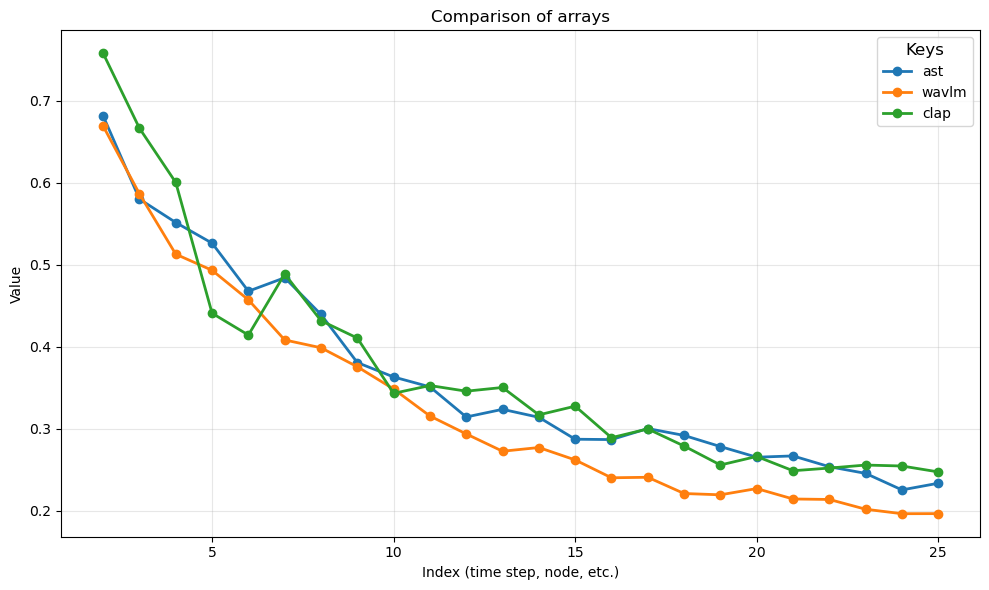

In [12]:
plt.figure(figsize=(10, 6))

for key, array in sil_scores_collection.items():
    plt.plot(k_ranges, array, label=key, marker="o", linewidth=2)

plt.legend(title="Keys", fontsize=10, title_fontsize=12, loc="best")
plt.xlabel("Index (time step, node, etc.)")
plt.ylabel("Value")
plt.title("Comparison of arrays")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [13]:
act_dict = {}
for k in list(sil_scores_collection.keys()):
    act_dict[k] = {str(i + 2): float(val) for i, val in enumerate(sil_scores_collection[k])}

In [14]:
act_dict

{'ast': {'2': 0.6812263102451612,
  '3': 0.579870490238299,
  '4': 0.551317788589451,
  '5': 0.5261730667243093,
  '6': 0.4675932516618964,
  '7': 0.48403946344446935,
  '8': 0.4392262604920386,
  '9': 0.3806574550632817,
  '10': 0.36308145435945866,
  '11': 0.3510443850373366,
  '12': 0.31432470270116447,
  '13': 0.32365079657486634,
  '14': 0.3139509374601127,
  '15': 0.28722175755196067,
  '16': 0.2867905543026262,
  '17': 0.3002259030883523,
  '18': 0.2918465736767373,
  '19': 0.27827288308526227,
  '20': 0.26529877863036555,
  '21': 0.2668797228329107,
  '22': 0.25373505726269496,
  '23': 0.24558953716286505,
  '24': 0.22545262438813823,
  '25': 0.2335707264957377},
 'wavlm': {'2': 0.668867198057312,
  '3': 0.5861993770026649,
  '4': 0.5126876379491748,
  '5': 0.49310881567596826,
  '6': 0.4570888167416043,
  '7': 0.4082123309914841,
  '8': 0.39867050613644855,
  '9': 0.37553117652016405,
  '10': 0.3483842624891384,
  '11': 0.31551286554744096,
  '12': 0.2936670257487253,
  '13': 

Run the spectral clustering algorithm in order to obtain clusters for each graph (corresponding to each embedding type).

In [16]:
num_clusters = 7
embedding_labels = {}

for col in embedding_cols:
    s_matrix = similarity_matrices[col]
    labels, X_norm = spectral_clustering(s_matrix, k=num_clusters)
    embedding_labels[col] = labels


In [17]:
similarity_matrices["wavlm"].shape

(2600, 2600)

### External Validation and graph visualization

100%|██████████| 2000/2000 [00:40<00:00, 49.63it/s]


BarnesHut Approximation  took  17.40  seconds
Repulsion forces  took  19.30  seconds
Gravitational forces  took  0.17  seconds
Attraction forces  took  1.88  seconds
AdjustSpeedAndApplyForces step  took  0.77  seconds


100%|██████████| 2000/2000 [00:43<00:00, 45.48it/s]


BarnesHut Approximation  took  14.28  seconds
Repulsion forces  took  26.03  seconds
Gravitational forces  took  0.15  seconds
Attraction forces  took  1.95  seconds
AdjustSpeedAndApplyForces step  took  0.77  seconds


100%|██████████| 2000/2000 [00:46<00:00, 42.83it/s]


BarnesHut Approximation  took  16.83  seconds
Repulsion forces  took  25.53  seconds
Gravitational forces  took  0.18  seconds
Attraction forces  took  2.35  seconds
AdjustSpeedAndApplyForces step  took  0.90  seconds


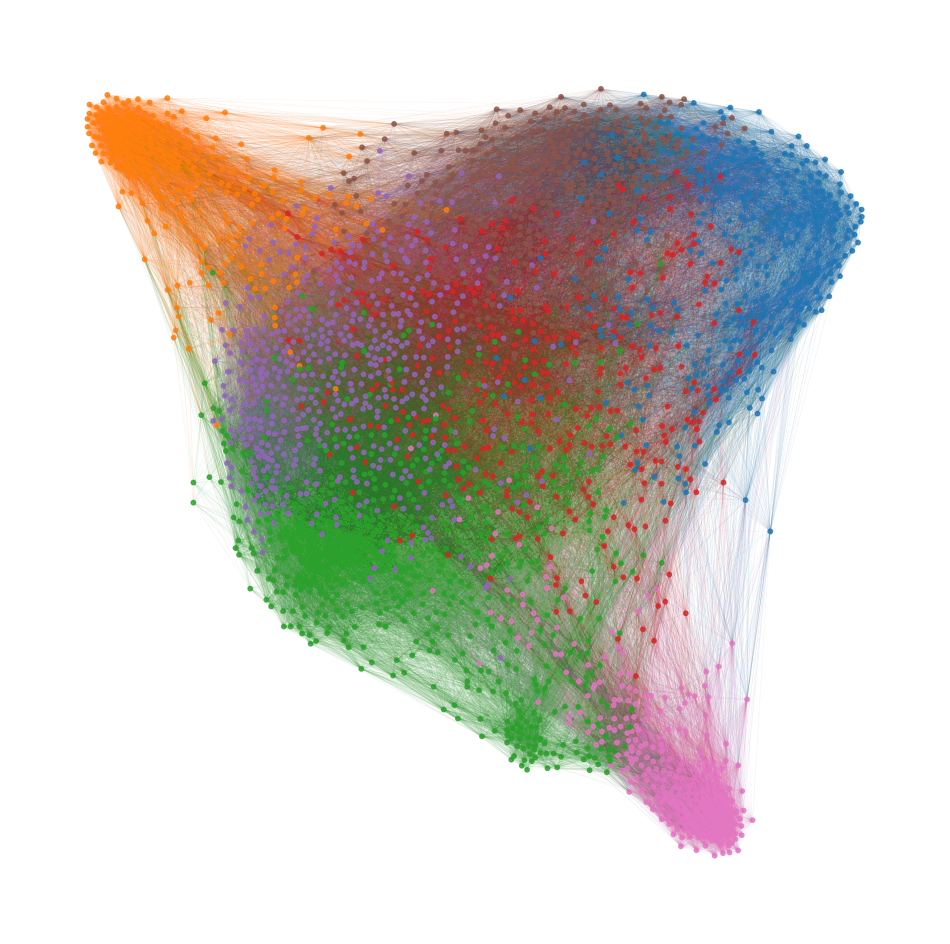

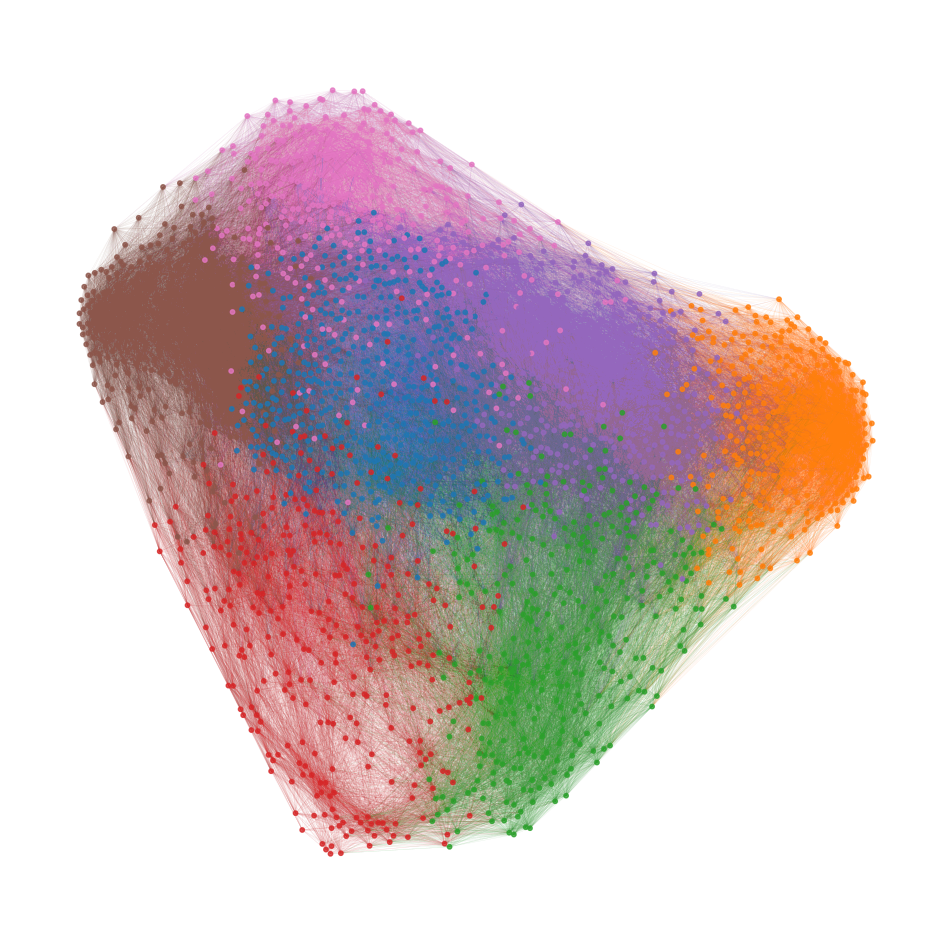

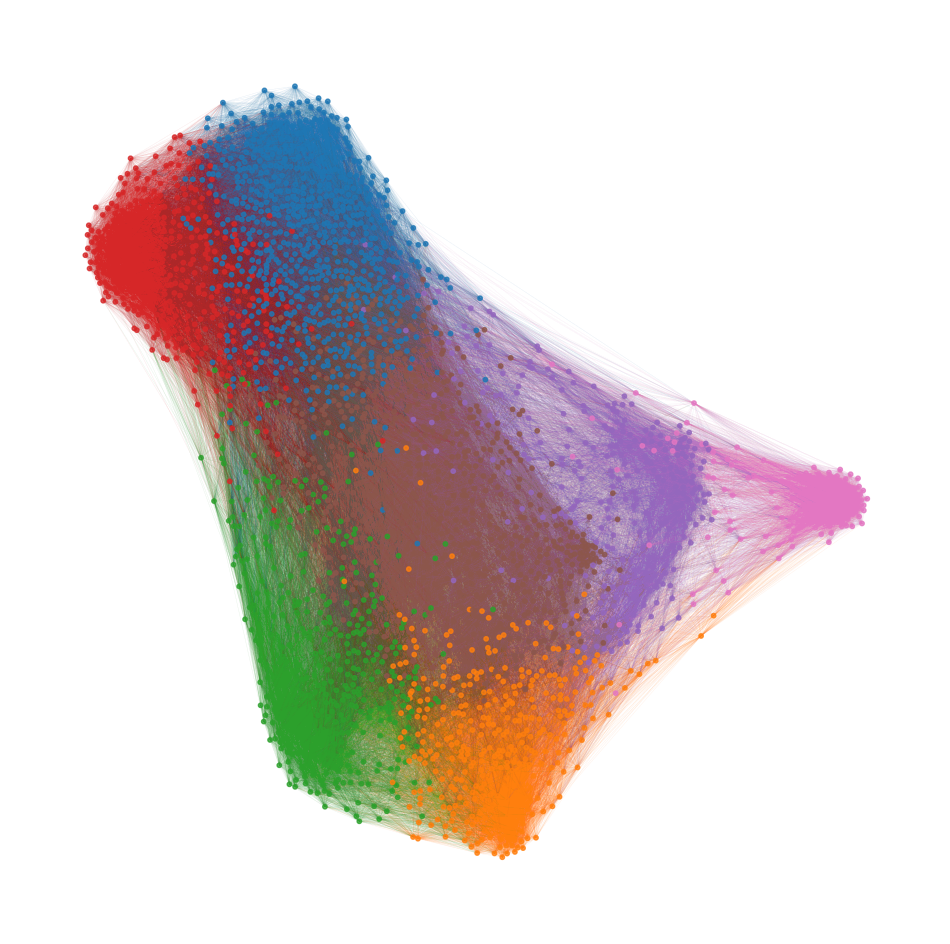

In [18]:
for col in embedding_cols:
    s_matrix = similarity_matrices[col]
    label = embedding_labels[col]
    filename = col

    visualize_graph(s_matrix, label, filename)

In [19]:
import json
from loguru import logger
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer


from typing import Dict, List, Optional, Any, Union

In [93]:
df_metadata = dfs['clap']
ast_df = df_metadata.copy()
ast_df["cluster_label"] = embedding_labels["clap"]

In [94]:
def column_wise_summary(
    df: pd.DataFrame,
    columns: List[str],
    save_path: str,
) -> None:
    """
    For each cluster and each column:
    - Count occurrences of each unique element.
    - Fully supports list-like columns (themes, keywords, companies).
    - Saves a JSON summary of value frequencies.

    Output format:
    {
        "0": {
            "themes": {"Action": 10, "Sci-fi": 4, ...},
            "keywords": {...},
            ...
        },
        "1": { ... },
        ...
    }
    """
    
    clusters = sorted(df["cluster_label"].unique())

    summary: Dict[Any, Dict[str, Dict[str, int]]] = {}

    for c in clusters:
        # Convert cluster label to JSON-serializable type
        c_key = str(int(c)) if isinstance(c, (np.integer, np.floating)) else str(c)
        subset = df[df["cluster_label"] == c]
        cluster_num = len(subset)
        
        summary[c_key] = {
            col: {} for col in columns
        }
        summary[c_key]["cluster_size"] = cluster_num
        
        for col in columns:
            logger.debug(f"Processing cluster {c_key}, column '{col}'…")
            subset = df[df["cluster_label"] == c]

            # Ensure the nested dict for this column exists
            if col not in summary[c_key]:
                summary[c_key][col] = {}

            if subset.empty:
                logger.warning(f"Cluster {c_key} has no entries for column '{col}'.")
                # Keep as empty dict for empty subsets
                continue
            

            # Flatten list values OR handle scalar values
            flat_values = []
            for item in subset[col]:
                if isinstance(item, str):
                    # Try to parse JSON string
                    try:
                        parsed = ast.literal_eval(item)
                        if isinstance(parsed, list):
                            flat_values.extend(parsed)
                        else:
                            flat_values.append(parsed)
                    except (ValueError, SyntaxError):
                        # Not JSON, treat as plain string
                        flat_values.append(item)
                elif isinstance(item, list):
                    flat_values.extend(item)
                else:
                    flat_values.append(item)

            counts = dict(Counter(flat_values))
            # Convert keys and values to JSON-serializable types
            counts = {str(k): int(v) for k, v in counts.items() if isinstance(v, (int, np.integer))}
            # Sort by count (descending)
            counts = dict(sorted(counts.items(), key=lambda x: -x[1]))
            # Store counts under a dedicated key to avoid overwriting
            summary[c_key][col]["counts"] = counts

    with open(save_path, "w") as f:
        json.dump(summary, f, indent=4)

    return None

In [95]:
column_wise_summary(ast_df, ["name", "themes", "keywords", "involved_companies", "first_release_year"], "../results/embedding_general/graph_clustering/gc.json")

2025-12-04 15:12:04.910 | DEBUG    | __main__:column_wise_summary:40 - Processing cluster 0, column 'name'…
2025-12-04 15:12:04.920 | DEBUG    | __main__:column_wise_summary:40 - Processing cluster 0, column 'themes'…
2025-12-04 15:12:04.925 | DEBUG    | __main__:column_wise_summary:40 - Processing cluster 0, column 'keywords'…
2025-12-04 15:12:04.963 | DEBUG    | __main__:column_wise_summary:40 - Processing cluster 0, column 'involved_companies'…
2025-12-04 15:12:04.969 | DEBUG    | __main__:column_wise_summary:40 - Processing cluster 0, column 'first_release_year'…
2025-12-04 15:12:04.972 | DEBUG    | __main__:column_wise_summary:40 - Processing cluster 1, column 'name'…
2025-12-04 15:12:04.975 | DEBUG    | __main__:column_wise_summary:40 - Processing cluster 1, column 'themes'…
2025-12-04 15:12:04.977 | DEBUG    | __main__:column_wise_summary:40 - Processing cluster 1, column 'keywords'…
2025-12-04 15:12:04.989 | DEBUG    | __main__:column_wise_summary:40 - Processing cluster 1, col

In [96]:
def tfidf_cluster_summary(
    df: pd.DataFrame,
    save_path: Optional[str] = None,
    k: int = 50,
    ngram_range=(1, 2),
    min_df: int = 1,
    max_df: float = 0.8,
    scoring: str = "distinctiveness",  # "distinctiveness" or "tfidf"
) -> Dict[Union[int, str], List[str]]:
    """
    Compute top-k keywords per cluster from the 'metadata' column.

    Uses a GLOBAL TF-IDF fit and selects terms that are
    distinctive to each cluster via:
        score = mean_tfidf_in_cluster - mean_tfidf_global

    Args:
        df: DataFrame containing 'cluster_label' and 'metadata' (or 'metadata_combined').
        k: Top-k terms to return per cluster.
        ngram_range: N-gram range for TF-IDF.
        min_df: Minimum doc frequency (absolute).
        max_df: Max document frequency ratio.
        scoring: 'distinctiveness' (default) or 'tfidf' (cluster mean TF-IDF).
    """

    if "cluster_label" not in df.columns:
        raise ValueError("DataFrame must contain 'cluster_label'.")

    if "metadata" in df.columns:
        text_col = "metadata"
    elif "metadata_combined" in df.columns:
        text_col = "metadata_combined"
    else:
        raise ValueError("DataFrame must contain 'metadata' or 'metadata_combined'.")

    all_texts = df[text_col].fillna("").astype(str).tolist()
    if len(all_texts) == 0 or all(t.strip() == "" for t in all_texts):
        return {}

    n_docs = len(all_texts)

    # Ensure max_df is consistent with min_df for small n_docs
    if isinstance(max_df, float) and max_df < 1.0:
        min_allowed_max_df = min_df / n_docs
        if max_df < min_allowed_max_df:
            max_df = min_allowed_max_df

    vectorizer = TfidfVectorizer(
        lowercase=True,
        stop_words="english",
        ngram_range=ngram_range,
        min_df=min_df,
        max_df=max_df,
    )

    try:
        tfidf_all = vectorizer.fit_transform(all_texts)
    except ValueError as e:
        # Usually "empty vocabulary" – relax constraints
        vectorizer = TfidfVectorizer(
            lowercase=True,
            stop_words=None,
            ngram_range=ngram_range,
            min_df=1,
            max_df=1.0,
        )
        tfidf_all = vectorizer.fit_transform(all_texts)

    if tfidf_all.shape[1] == 0:
        # Still nothing – bail out gracefully
        return {}

    feature_names = np.array(vectorizer.get_feature_names_out())
    global_mean = np.asarray(tfidf_all.mean(axis=0)).ravel()

    results: Dict[Union[int, str], List[str]] = {}
    clusters = df["cluster_label"].unique()

    for cluster in clusters:
        idx = np.where(df["cluster_label"].values == cluster)[0]
        if len(idx) == 0:
            results[cluster] = []
            continue

        tfidf_cluster = tfidf_all[idx, :]
        if tfidf_cluster.shape[0] == 0:
            results[cluster] = []
            continue

        cluster_mean = np.asarray(tfidf_cluster.mean(axis=0)).ravel()

        if scoring == "tfidf":
            scores = cluster_mean
        else:
            scores = cluster_mean - global_mean

        if scores.size == 0:
            results[cluster] = []
            continue

        top_idx = np.argsort(scores)[::-1][:k]
        results[cluster] = feature_names[top_idx].tolist()

    # JSON can't handle np.int64 keys
    results = {int(c): v for c, v in results.items()}

    if save_path:
        logger.info(f"Saving TF-IDF cluster summary to {save_path}")
        with open(save_path, "w") as f:
            json.dump(results, f, indent=4)

    return results

In [97]:
tfidf_cluster_summary(ast_df, "../results/embedding_general/graph_clustering/gc_all.json")

2025-12-04 15:12:11.929 | INFO     | __main__:tfidf_cluster_summary:108 - Saving TF-IDF cluster summary to ../results/embedding_general/graph_clustering/gc_all.json


{1: ['zelda',
  'legend',
  'legend zelda',
  'nintendo imagica',
  'zelda twilight',
  'imagica digitalscape',
  'imagica',
  'fantasy zelda',
  'twilight princess',
  'zelda motion',
  'digitalscape',
  'twilight',
  'princess action',
  'control nintendo',
  'ead software',
  'group nintendo',
  'software development',
  'development group',
  'development',
  'motion',
  'software',
  'group',
  'nintendo',
  'motion control',
  'action fantasy',
  'control',
  'fantasy',
  'nintendo ead',
  'ead',
  'princess',
  'advergame',
  'advergame nintendo',
  'fiction advergame',
  'prime science',
  'metroid',
  'metroid prime',
  'square',
  'prime',
  'square enix',
  'enix',
  'auto aim',
  'aim',
  'blur',
  'motion blur',
  'designs',
  'archery action',
  'imprisonment',
  'escaping imprisonment',
  'escaping',
  'living'],
 2: ['super',
  'gamecube retroachievements',
  'game console',
  'canceling',
  'animation canceling',
  'pok mon',
  'mon',
  'platform fighting',
  'smash',


/var/folders/4l/6stdwbh56pvgwz8thwnlgtq80000gn/T/ipykernel_13218/3306556391.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  tab10 = cm.get_cmap('tab10')



=== first_release_year ===


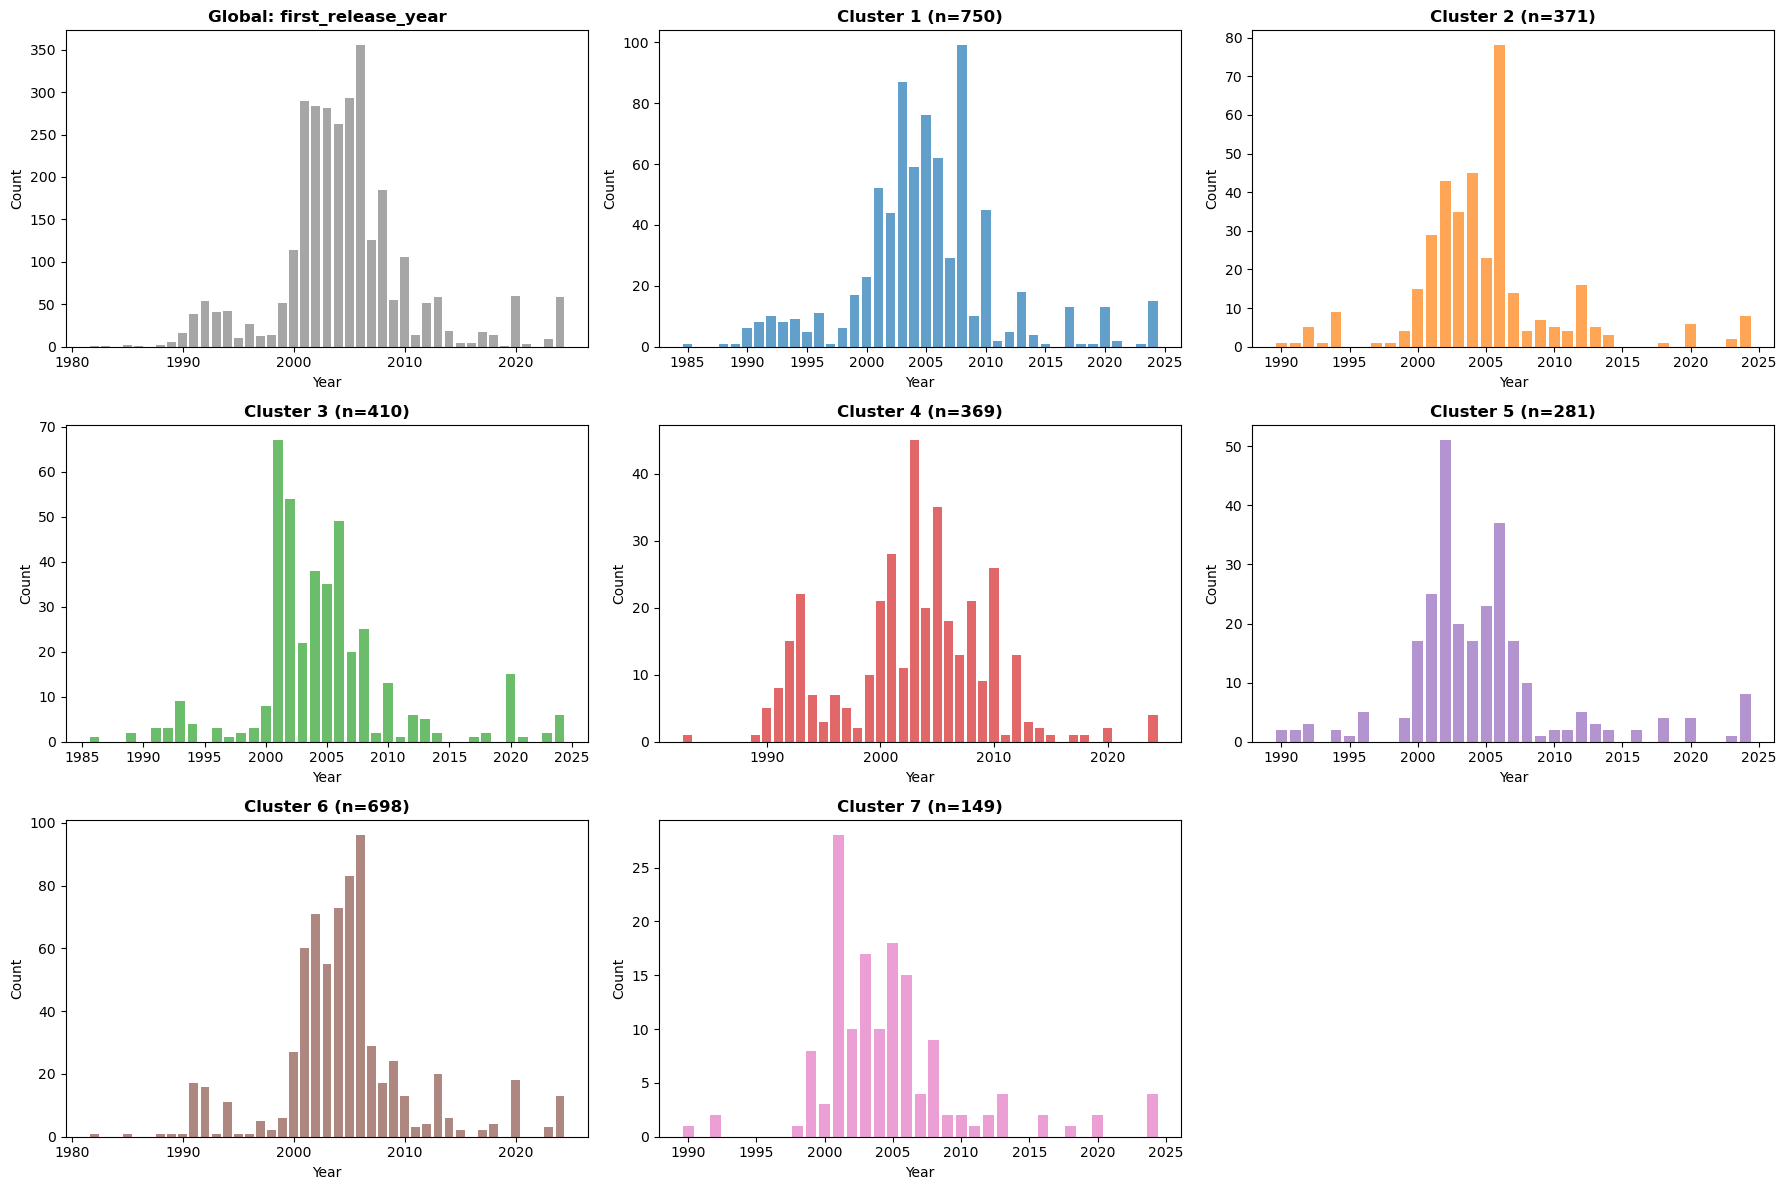


=== involved_companies ===


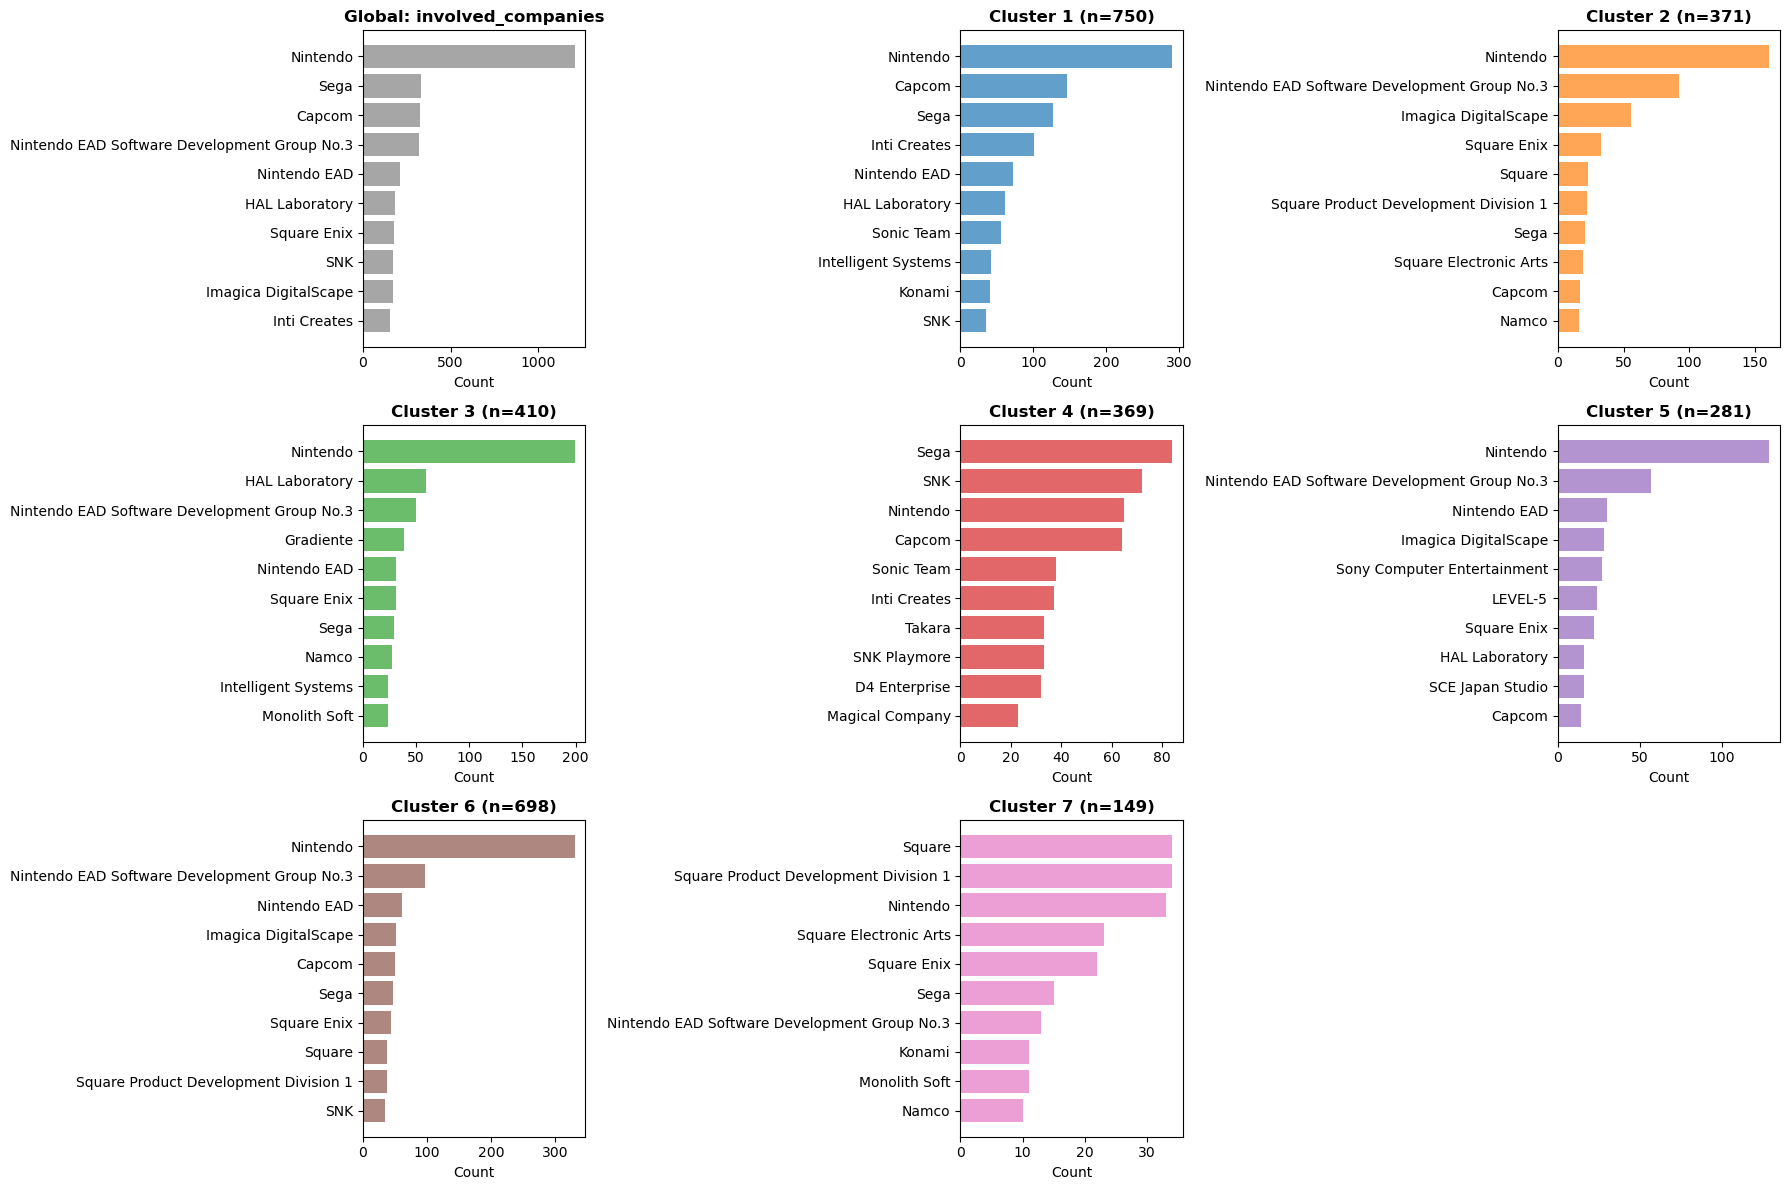


=== keywords ===


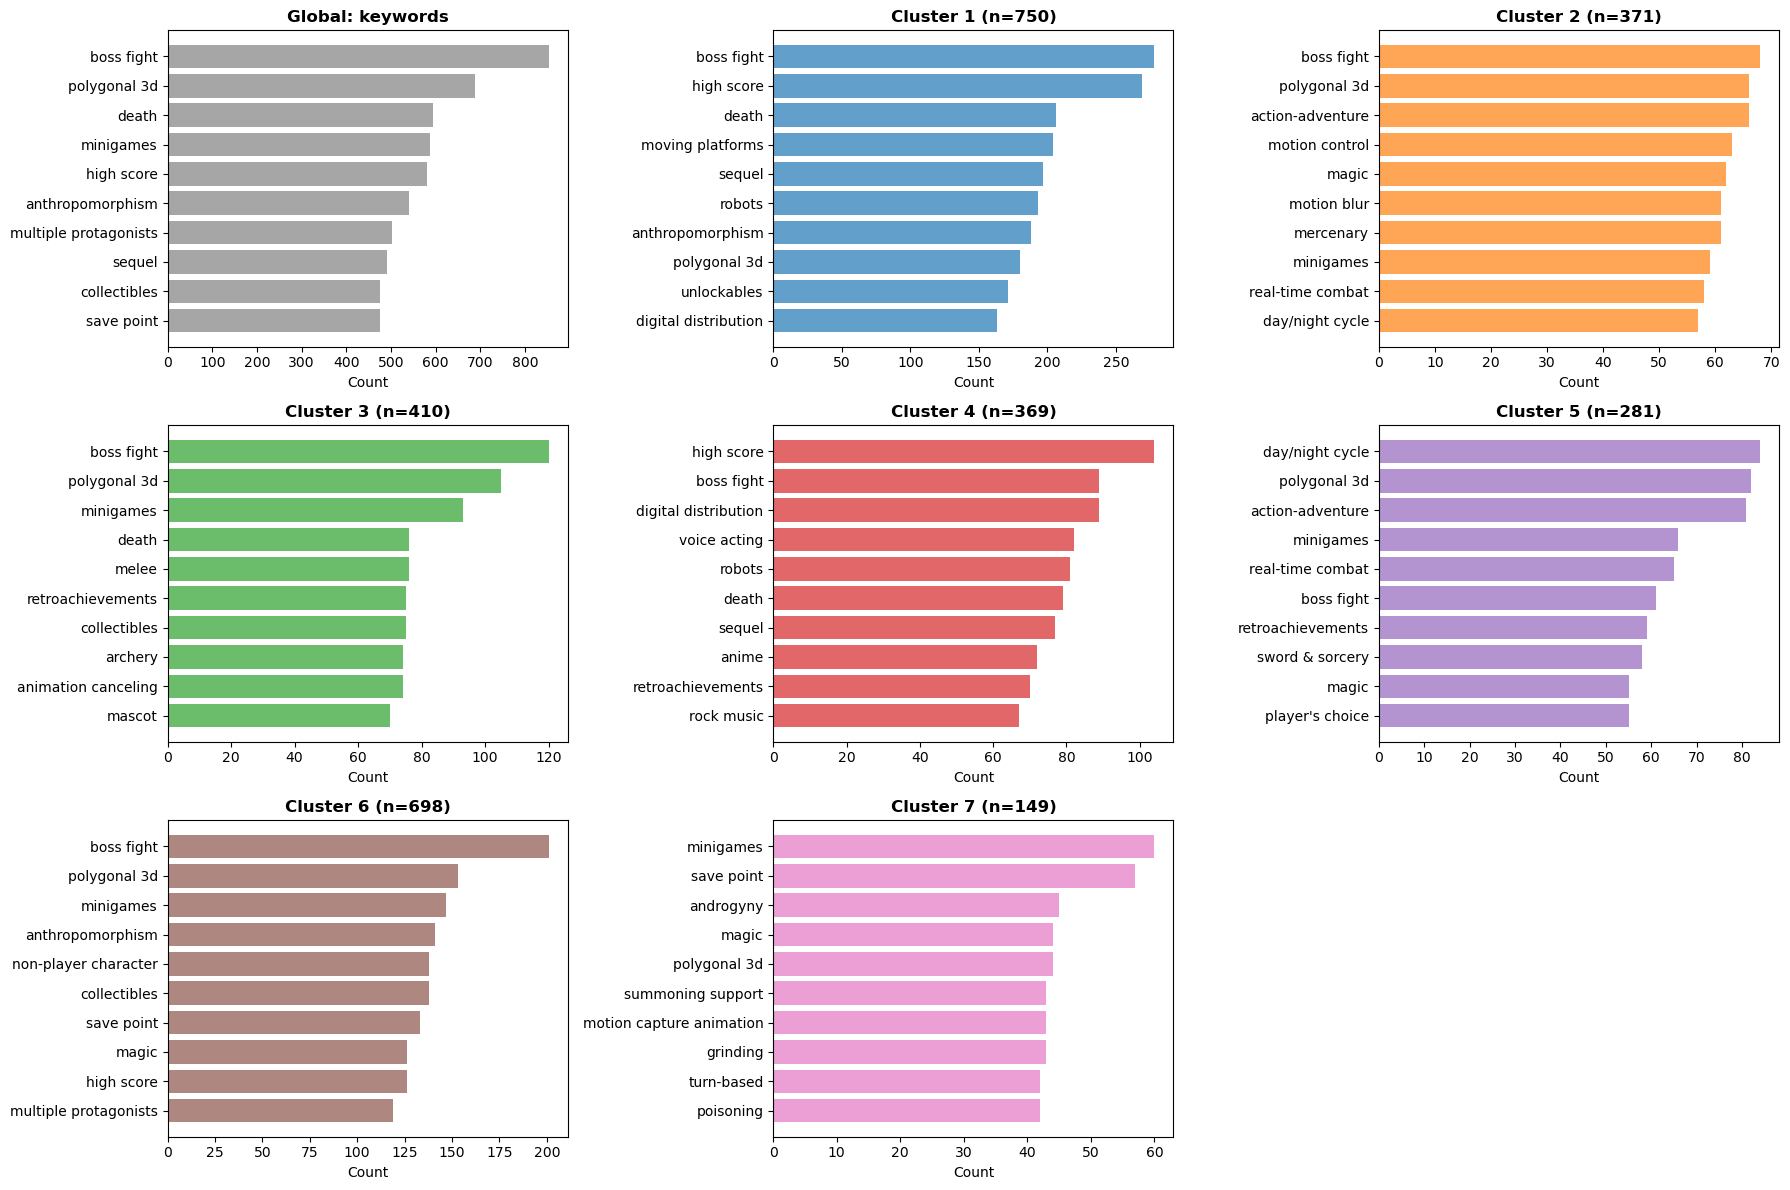


=== name ===


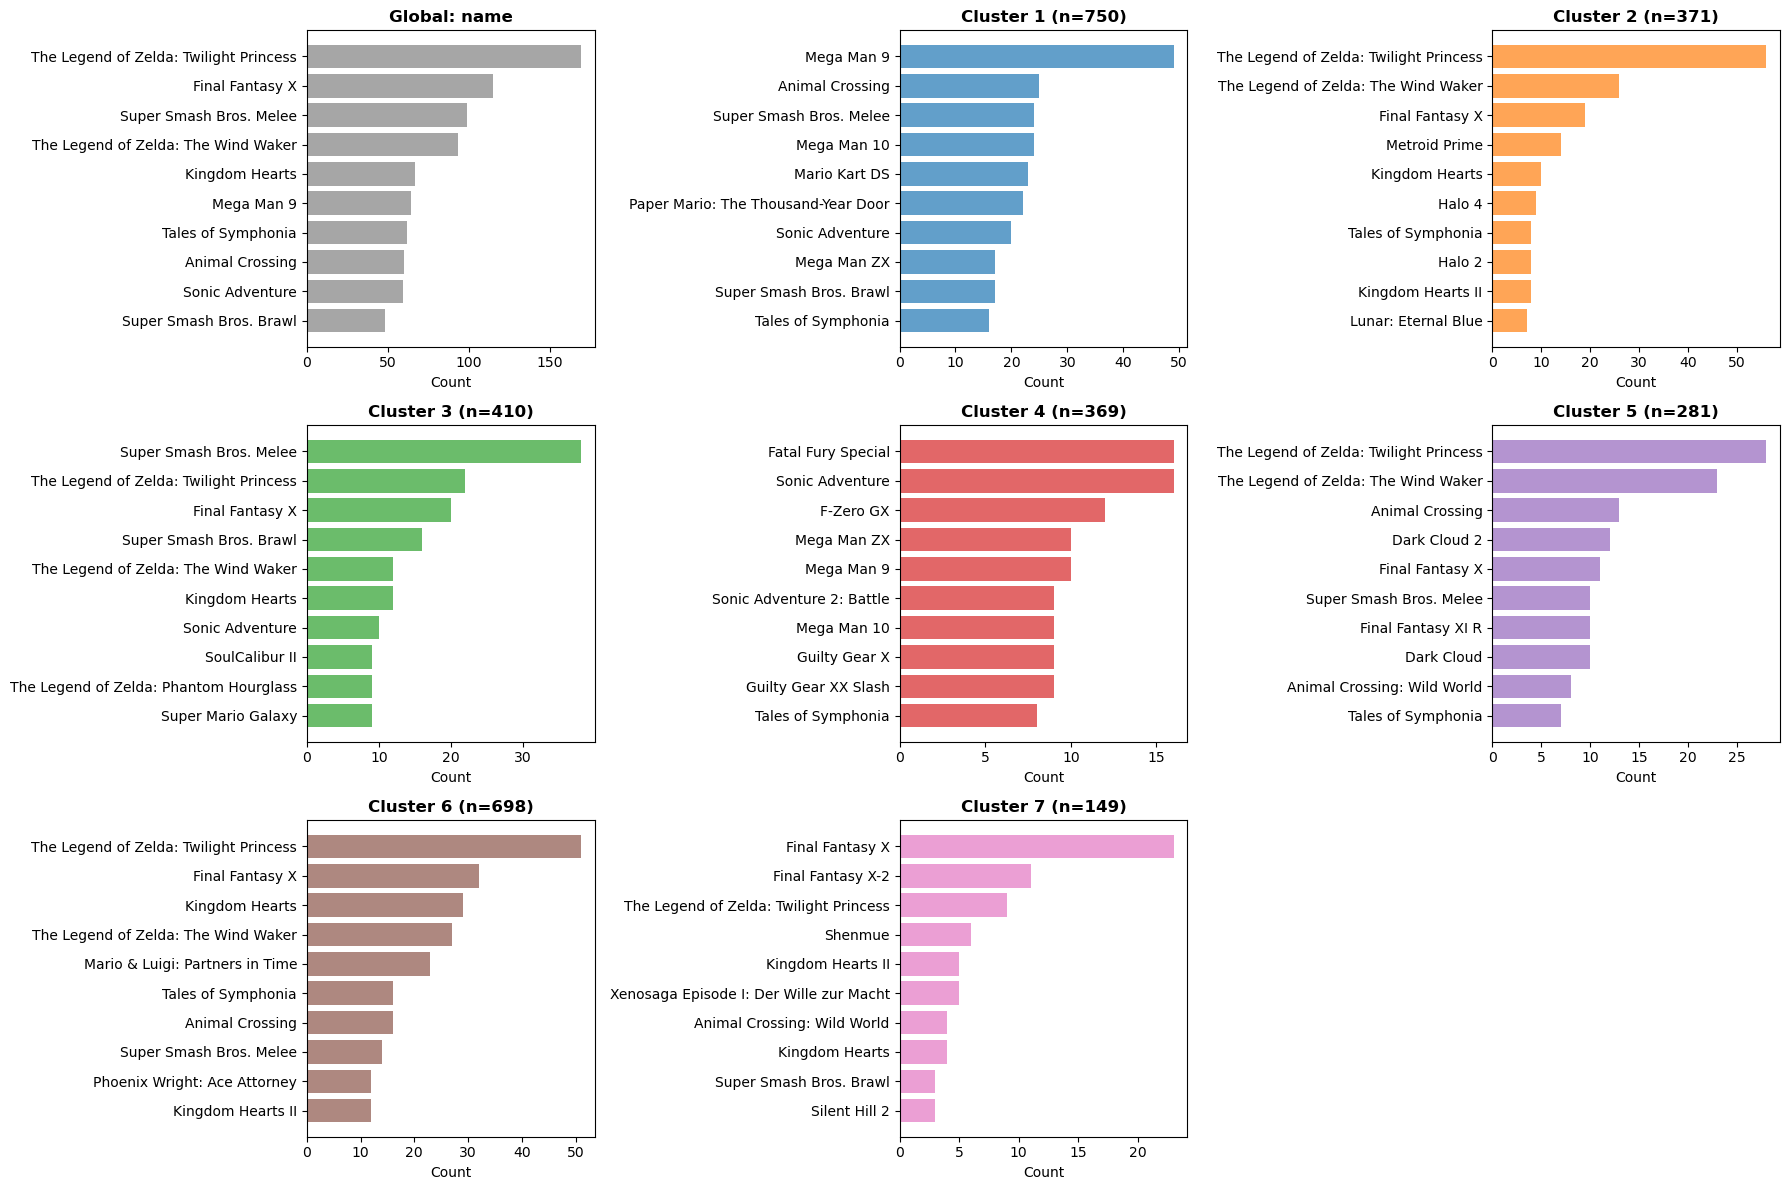


=== themes ===


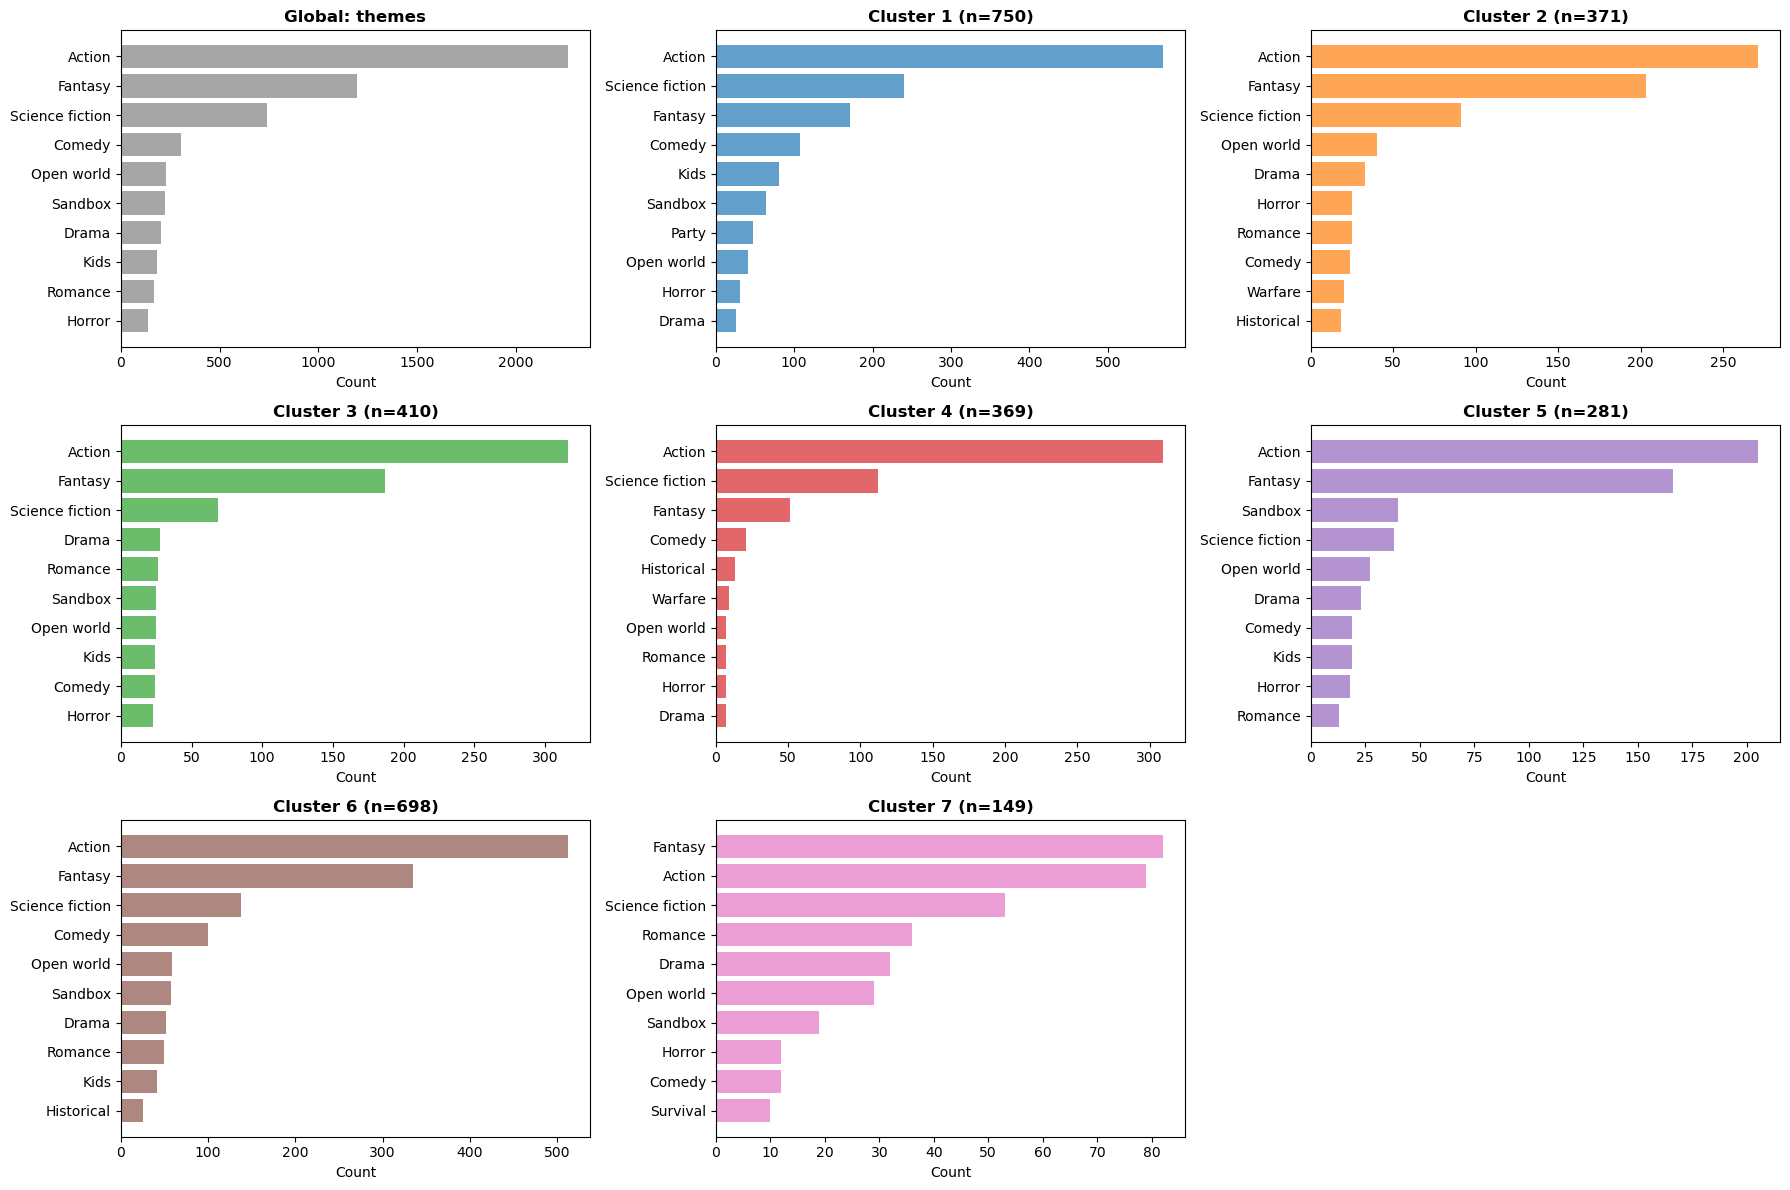


=== Cluster Sizes ===


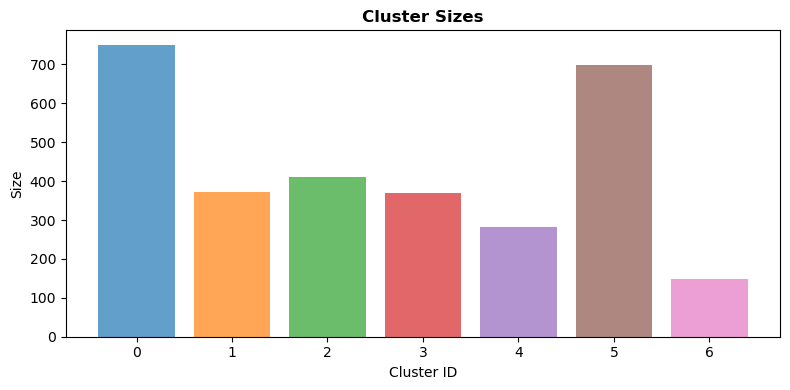

In [98]:



col_summary = {}
with open("../results/embedding_general/graph_clustering/gc.json", 'r') as f:
    col_summary = json.load(f)


plot_metadata_distributions(col_summary, top_n=10)

Assess 

In [78]:
col_summary = {}
with open("../results/embedding_general/graph_clustering/gc_all.json", 'r') as f:
    col_summary = json.load(f)

col_summary

{'1': ['namco',
  'tales',
  'zelda',
  'action fantasy',
  'studio',
  'stage treasure',
  'konami',
  'nintendo namco',
  'tales studio',
  'namco tales',
  'magic manga',
  'manga jrpg',
  'leveling ice',
  'syndrome fast',
  'gamecube bandai',
  'namco holdings',
  'symphonia action',
  'holdings namco',
  'bread women',
  'holdings',
  'jrpg block',
  'puzzle leveling',
  'potion bread',
  'traveling warping',
  'warping gamecube',
  'chest potion',
  'symphonia',
  'tales symphonia',
  'fantasy anime',
  'bandai namco',
  'bandai',
  'studio nintendo',
  'block puzzle',
  'jrpg',
  'princess action',
  'women',
  'syndrome',
  'women refrigerators',
  'refrigerators',
  'refrigerators syndrome',
  'warping',
  'fantasy zelda',
  'twilight princess',
  'nintendo imagica',
  'zelda motion',
  'imagica',
  'zelda twilight',
  'imagica digitalscape',
  'digitalscape',
  'twilight'],
 '3': ['musical industries',
  'jvc',
  'jvc musical',
  'musical',
  'action combat',
  'victor',
  '

In [80]:

from itertools import combinations

def cluster_jaccard_similarity(topic_words_dict):
    clusters = list(topic_words_dict.keys())
    similarities = []
    
    for (c1, c2) in combinations(clusters, 2):
        set1 = set(topic_words_dict[c1])
        set2 = set(topic_words_dict[c2])
        jaccard = len(set1 & set2) / len(set1 | set2)
        similarities.append(((c1, c2), jaccard))
    
    # Sort by similarity (highest first)
    similarities.sort(key=lambda x: x[1], reverse=True)

    for (c1, c2), score in similarities[:10]:
        print(f"Cluster {c1} ↔ {c2}: {score:.3f}")
    print(similarities)

    return similarities

# Usage
sims = cluster_jaccard_similarity(col_summary)


Cluster 0 ↔ 4: 0.075
Cluster 6 ↔ 5: 0.042
Cluster 3 ↔ 4: 0.020
Cluster 6 ↔ 2: 0.020
Cluster 1 ↔ 6: 0.010
Cluster 1 ↔ 2: 0.010
Cluster 3 ↔ 0: 0.010
Cluster 1 ↔ 3: 0.000
Cluster 1 ↔ 0: 0.000
Cluster 1 ↔ 4: 0.000
[(('0', '4'), 0.07526881720430108), (('6', '5'), 0.041666666666666664), (('3', '4'), 0.02040816326530612), (('6', '2'), 0.02040816326530612), (('1', '6'), 0.010101010101010102), (('1', '2'), 0.010101010101010102), (('3', '0'), 0.010101010101010102), (('1', '3'), 0.0), (('1', '0'), 0.0), (('1', '4'), 0.0), (('1', '5'), 0.0), (('3', '6'), 0.0), (('3', '2'), 0.0), (('3', '5'), 0.0), (('0', '6'), 0.0), (('0', '2'), 0.0), (('0', '5'), 0.0), (('6', '4'), 0.0), (('2', '4'), 0.0), (('2', '5'), 0.0), (('4', '5'), 0.0)]
